In [1]:
from casadi import Opti,log,exp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from subset_helper import bax

Randomly initialize parameters. Individuals and facilities are distributed uniformly randomly around a unit square. Individual types $\theta_i \sim \text{Bernoulli}(\frac{1}{2})$. That is,
$$
\theta_i=\begin{cases} 
0 : \text{ w.p. } \frac{1}{2}\\
1 : \text{ w.p. } \frac{1}{2}.
\end{cases}
$$

Distances between individuals and facilities are stored in matrix `dist`.

In [2]:
sizeRegion = 1
nIndiv = 100
nFac = 15
nSelectedFac = 6
fac = np.random.uniform(0,sizeRegion,(nFac, 2))
indiv = np.random.uniform(0,sizeRegion,(nIndiv, 2))
theta = np.array([np.random.choice([0,1]) for i in range(nIndiv)])
dist = np.array([[ (indiv[i,0] - fac[j,0])**2 + (indiv[i,1] - fac[j,1])**2 for j in range(0,nFac)] for i in range(0,nIndiv)]) # nIndiv X nFac

The stochastic model is that

$$
P(\text{success of individual } i) = f(\theta_i,r_i)= \frac{1}{1 + e^{-(\beta_0 + \beta_\theta \theta_i + \beta_r r_i)}}.
$$
where $r_i$ represents the distance of individual $i$ from the nearest selected facility, and $\beta_r <0$ indicates that increasing distance causes decreased probability of success. Higher type $\theta_i$ corresponds to a higher probability of success, so $\beta_\theta >0$.

In this code, $\beta_0=0$, so a type-$0$ individual ($\theta_i = 0$) with no distance to the nearest facility ($r_i=0$) has precisely a $\frac{1}{2}$ probability of success. Increasing $\beta_0$ increases the probability of success for all individuals.

We let $\beta = (\beta_0, \beta_\theta, \beta_r)$.

In [3]:
beta = [0,1,-1] #[beta0, beta_theta >0, beta_r <0]

We implement the following optimization model in the `CasADI` Python interface to COIN-OR's `Bonmin` MINLP solver:

$$
\begin{array}{llll}
            \max & \displaystyle\sum_{i=1}^N u_i & &\\
            \text{s.t.} & u_i &= f(\theta_i,r_i),&i = 1,\ldots,N\\
                        & r_i &\ge d_{ij} x_{ij},&i=1,\ldots,N,j=1,\ldots,M\\
                        & \displaystyle\sum_{j=1}^M x_{ij} &=1,&i=1,\ldots,N\\
                        & x_{ij} &\le y_j, &i=1,\ldots,N,j=1,\ldots,M\\
                        &\displaystyle\sum_{j=1}^M y_j &\le m&\\
                        & x_{ij},y_j &\in \{0,1\},&i=1,\ldots,N,j=1,\ldots,M. 
\end{array}
$$

In [4]:
def solve_casadi():
	opti = Opti()
	x = [[opti.variable() for j in range(nFac)] for i in range(nIndiv)] # nIndiv X nFac
	y = [opti.variable() for j in range(nFac)]
	r = [opti.variable() for i in range(nIndiv)]
	u = [opti.variable() for i in range(nIndiv)]
	discrete = []
	discrete += [True  for j in range(nFac) for i in range(nIndiv)] #x variables
	discrete += [True  for j in range(nFac)] #y variables
	discrete += [False for i in range(nIndiv)] #r variables
	discrete += [False for i in range(nIndiv)] #u variables
	opti.minimize(-sum(u))#maximize sum u
	opti.subject_to([u[i] == -log(1+exp(-beta[0] - beta[1]*theta[i] - beta[2]*r[i])) for i in range(nIndiv)]) #log prob(success)
	# opti.subject_to([u[i] == 1/(1+exp(-beta[0] - beta[1]*theta[i] - beta[2]*r[i])) for i in range(nIndiv)]) #prob(success)
	opti.subject_to([r[i] >= dist[i,j]*x[i][j] for i in range(nIndiv) for j in range(nFac)])
	opti.subject_to([ sum(x[i]) == 1 for i in range(nIndiv) ])
	opti.subject_to([ x[i][j] <= y[j] for i in range(nIndiv) for j in range(nFac)])
	opti.subject_to(sum(y) <= nSelectedFac)
	opti.subject_to([ opti.bounded(0,y[j],1) for j in range(nFac)])
	opti.subject_to([ opti.bounded(0,x[i][j],1) for i in range(nIndiv) for j in range(nFac)])
	p_options = {"discrete":discrete,"expand":True}
	s_options = {"max_iter": 100}
	opti.solver('bonmin',p_options,s_options)
	sol = opti.solve()
	xvals = np.array([[int(sol.value(x[i][j])) for j in range(nFac)] for i in range(nIndiv)])
	yvals = np.array([int(sol.value(y[j])) for j in range(nFac)])
	rvals = np.array([sol.value(r[i]) for i in range(nIndiv)])
	uvals = np.array([sol.value(u[i]) for i in range(nIndiv)])
	# prob_success = np.array([1/(1+exp(-beta[0] - beta[1]*theta[i] - beta[2]*rvals[i])) for i in range(nIndiv)])
	prob_success = np.exp(uvals)
	fstar = sol.value(opti.f)
	print(f"Solved using CasADI")
	return xvals,yvals,rvals,uvals,prob_success,fstar



def solve_enumerative():
	bbax=bax()
	en = bbax.enumerator
	xvals = np.zeros((nIndiv,nFac),dtype=int)
	yvals = np.zeros((nFac),dtype=int)
	rvals = np.zeros((nIndiv))
	uvals = np.full((nIndiv),-np.inf)

	for ind, gp in enumerate(bbax.bax_gen(nFac,nSelectedFac)):
		gp = gp.toList()
		# print(locals())
		# print(f"gp: {gp}, gp_dists: {[dist[i][j] for j in gp]}, ")
		xlist = [ gp[np.argmin([dist[i][j] for j in gp])] for i in range(nIndiv)]
		r = [dist[i][xlist[i]] for i in range(nIndiv)]
		u = [-log(1+exp(-beta[0] - beta[1]*theta[i] - beta[2]*r[i])) for i in range(nIndiv)]
		if sum(u) > sum(uvals):
			uvals = u
			rvals = r
			yvals = np.zeros((nFac),dtype=int)
			yvals[gp] = 1

	xvals[range(nIndiv),xlist] = 1
	fstar = sum(uvals)
	prob_success = np.exp(uvals)
	print(f"Solved enumeratively")
	return xvals,yvals,rvals,uvals,prob_success,fstar

def plot_region(title_extra=""):
	number_desired_colors = 6
	cmap = plt.cm.get_cmap('nipy_spectral',number_desired_colors)
	colors = [cmap(i) for i in range(number_desired_colors)]
	fig, ax = plt.subplots(figsize=(10,10))
	plt.axis('off')
	title = f"Region with facilities and individuals\n(higher type -> success more likely)"
	if len(title_extra) > 0:
		title = f"{title}\n{title_extra}"
	plt.title(title)

	## Plot Region
	region = patches.Rectangle((0,0),sizeRegion,sizeRegion,linewidth=1,edgecolor=colors.pop(),facecolor="none")
	ax.add_patch(region)

	## Plot Objectives
	def plotObjectives():
		cm = plt.cm.get_cmap('gist_rainbow')
		obj_scatter = plt.scatter(indiv[:,0],indiv[:,1],marker="o",s=14**2,lw=2,alpha=0.5,c=prob_success,cmap="gist_rainbow",label="no_legend")
		obj_scatter.set_facecolor('none')
		cbar = plt.colorbar(obj_scatter)
		plt.clim(0,1)
		cbar.ax.set_ylabel('P(success)')
	plotObjectives()

	## Plot Individuals
	labelIndividuals = "Individual"
	def plotIndividuals():
		color_weight_map = {ttheta : colors.pop() for ttheta in set(theta)}
		individual_colors = [color_weight_map[ttheta] for ttheta in theta]
		individual_labels = [f"{labelIndividuals} type {ttheta}" for coords,ttheta in zip(indiv,theta)]
		for i,coords in enumerate(indiv):
			plt.scatter(*coords,marker = "*",c=[individual_colors[i]],label=individual_labels[i])
	plotIndividuals()

	## Plot Facilities
	labelFacility = "Facility"
	def plotFacilities():
		size_options = [5**2,9**2]
		facility_sizes = [size_options[yval] for yval in yvals]
		facility_color_map = {yval : colors.pop() for yval in set(yvals)}
		facility_colors = [facility_color_map[yval] for yval in yvals]
		facility_states = ["Omitted", "Selected"]
		facility_labels = [f"{facility_states[yval]} {labelFacility}" for yval in yvals]
		for i, coords in enumerate(fac):
			plt.scatter(*coords,marker = "+",c=[facility_colors[i]],s=[facility_sizes[i]],label=facility_labels[i])
	plotFacilities()

	## Create Legend
	# legend_dict = {legendTitle : artist for artist in ax.collections.copy() + ax.lines.copy() if "no_legend" not in (legendTitle:=artist.properties().get('label'))} #Python 3.8
    legend_dict = {artist.properties().get('label') : artist for artist in ax.collections.copy() + ax.lines.copy() if "no_legend" not in artist.properties().get('label')} #Python 3.7
    plt.legend(legend_dict.values(),legend_dict.keys(),loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(legend_dict),fontsize='small') #,loc="upper right"
	plt.show(block=False)
	return fig,ax

## Solve and Plot the solution:

Solved enumeratively


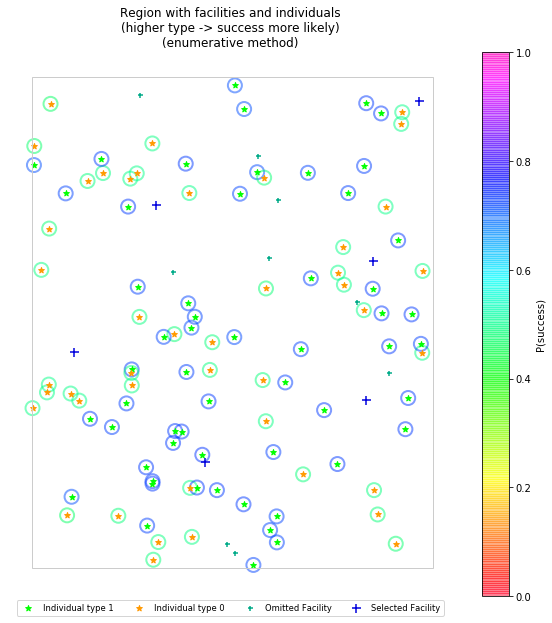

In [5]:
xvals,yvals,rvals,uvals,prob_success,fstar = solve_enumerative()


fig,ax = plot_region("(enumerative method)")